In [779]:
from io import open
import random

# 深度学习库pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import math
import torch.nn.functional as F
from torch.utils.data import TensorDataset
# 用于绘制损失函数下降曲线
from matplotlib import pyplot as plt
# %pdb off

# 模型构建

## 数据集导入

In [780]:
# 单行诗最大长度
MAX_LEN = 64
MIN_LEN = 5
# 禁用的字符，拥有以下符号的诗将被忽略
DISALLOWED_WORDS = ['（', '）', '(', ')', '__', '《', '》', '【', '】', '[', ']', '？', '；']

# 一首诗（一行）对应一个列表的元素
poetry = []

# 按行读取数据 poetry.txt
with open('./data/poetry.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
# 遍历处理每一条数据    
for line in lines:
    # 利用正则表达式拆分 标题 和 内容
    fields = line.split(":")
    # 跳过异常数据
    if len(fields) != 2:
        continue
    # 得到诗词内容（后面不需要标题）
    content = fields[1]
    # 过滤数据：跳过内容过长、过短、存在禁用符的诗词
    if len(content) > MAX_LEN - 2 or len(content) < MIN_LEN:
        continue
    if any(word in content for word in DISALLOWED_WORDS):
        continue
        
    poetry.append(content.replace('\n', '')) # 最后要记得删除换行符


In [781]:
for i in range(0, 10):
    print(poetry[i])
    
print(f"current_line_count = {len(poetry)}")

寒随穷律变，春逐鸟声开。初风飘带柳，晚雪间花梅。碧林青旧竹，绿沼翠新苔。芝田初雁去，绮树巧莺来。
晚霞聊自怡，初晴弥可喜。日晃百花色，风动千林翠。池鱼跃不同，园鸟声还异。寄言博通者，知予物外志。
夏律昨留灰，秋箭今移晷。峨嵋岫初出，洞庭波渐起。桂白发幽岩，菊黄开灞涘。运流方可叹，含毫属微理。
寒惊蓟门叶，秋发小山枝。松阴背日转，竹影避风移。提壶菊花岸，高兴芙蓉池。欲知凉气早，巢空燕不窥。
山亭秋色满，岩牖凉风度。疏兰尚染烟，残菊犹承露。古石衣新苔，新巢封古树。历览情无极，咫尺轮光暮。
慨然抚长剑，济世岂邀名。星旗纷电举，日羽肃天行。遍野屯万骑，临原驻五营。登山麾武节，背水纵神兵。在昔戎戈动，今来宇宙平。
翠野驻戎轩，卢龙转征旆。遥山丽如绮，长流萦似带。海气百重楼，岩松千丈盖。兹焉可游赏，何必襄城外。
玄兔月初明，澄辉照辽碣。映云光暂隐，隔树花如缀。魄满桂枝圆，轮亏镜彩缺。临城却影散，带晕重围结。驻跸俯九都，停观妖氛灭。
碧原开雾隰，绮岭峻霞城。烟峰高下翠，日浪浅深明。斑红妆蕊树，圆青压溜荆。迹岩劳傅想，窥野访莘情。巨川何以济，舟楫伫时英。
春蒐驰骏骨，总辔俯长河。霞处流萦锦，风前漾卷罗。水花翻照树，堤兰倒插波。岂必汾阴曲，秋云发棹歌。
current_line_count = 24375


In [782]:
from collections import Counter
# 最小词频
MIN_WORD_FREQUENCY = 8

# 统计词频，利用Counter可以直接按单个字符进行统计词频
counter = Counter()
for line in poetry:
    counter.update(line)
# 过滤掉低词频的词
tokens = [token for token, count in counter.items() if count >= MIN_WORD_FREQUENCY]
# 打印一下出现次数前5的字
for i, (token, count) in enumerate(counter.items()):
    print(token, "->",count)
    if i >= 4:
        break

寒 -> 2612
随 -> 1036
穷 -> 482
律 -> 118
变 -> 286


## 类定义

### 编码器

In [783]:
class Tokenizer:
    """
    词典编码器
    """
    UNKNOWN = "<unknown>"
    PAD = "<pad>"
    BOS = "<bos>" 
    EOS = "<eos>" 

    def __init__(self, tokens):
        # 补上特殊词标记：未知词标记、填充字符标记、开始标记、结束标记
        tokens = [Tokenizer.UNKNOWN, Tokenizer.PAD, Tokenizer.BOS, Tokenizer.EOS] + tokens
        # 词汇表大小
        self.dict_size = len(tokens)
        # 生成映射关系
        self.token_id = {} # 映射: 词 -> 编号
        self.id_token = {} # 映射: 编号 -> 词
        for idx, word in enumerate(tokens):
            self.token_id[word] = idx
            self.id_token[idx] = word
        
        # 各个特殊标记的编号id，方便其他地方使用
        self.unknown_id = self.token_id[Tokenizer.UNKNOWN]
        self.pad_id = self.token_id[Tokenizer.PAD]
        self.bos_id = self.token_id[Tokenizer.BOS]
        self.eos_id = self.token_id[Tokenizer.EOS]
    
    def id_to_token(self, token_id):
        """
        编号 -> 词
        """
        return self.id_token.get(token_id)

    def token_to_id(self, token):
        """
        词 -> 编号，取不到时给 UNKNOWN
        """
        return self.token_id.get(token, self.unknown_id)

    def encode(self, tokens):
        """
        词列表 -> <bos>编号 + 编号列表 + <eos>编号
        """
        token_ids = [self.bos_id, ] # 起始标记
        # 遍历，词转编号
        for token in tokens:
            token_ids.append(self.token_to_id(token))
        token_ids.append(self.eos_id) # 结束标记
        return token_ids

    def decode(self, token_ids):
        """
        编号列表 -> 词列表(去掉起始、结束标记)
        """
        tokens = []
        for idx in token_ids:
            # 跳过起始、结束标记
            if idx != self.bos_id and idx != self.eos_id:
                tokens.append(self.id_to_token(idx))
        return tokens
    
    def __len__(self):
        return self.dict_size


### index和独热向量互化

In [784]:
def index2onehot(word_ids, vocab_size):
    r"""
    由索引转化为独热编码
    Args:
        word_ids (torch.Tensor): 
            A 1D or 2D tensor containing word indices. 
            (seq_len, ) or (batch_size, seq_len)

        vocab_size (int): 
            The size of the vocabulary.

    Returns: 
        torch.Tensor: 
            A tensor containing one-hot encoded vectors.
            (seq_len, vocab_size) or (batch_size, seq_len, vocab_size)

    Raises:
        ValueError: If `word_ids` is not a 1D or 2D tensor.
    """
    if word_ids.dim() == 1:
        # 一维情况：(seq_len,)
        onehot_tensor = torch.zeros(len(word_ids), vocab_size)
        for i, s in enumerate(word_ids): 
            onehot_tensor[i, s] = 1
    elif word_ids.dim() == 2:
        # 二维情况：(batch_size, seq_len)
        batch_size, seq_len = word_ids.size()
        onehot_tensor = torch.zeros(batch_size, seq_len, vocab_size, dtype=torch.float32)
        onehot_tensor.scatter_(2, word_ids.unsqueeze(2), 1)
    else:
        raise ValueError("word_ids must be a 1D or 2D tensor")
    return onehot_tensor

def onehot2index(word_ids):
    """
    独热编码转化为索引 (*, vocab_size) ---> (*,)
    """
    return torch.argmax(word_ids, dim=-1)


### 数据集类

In [785]:
class MyDataset(TensorDataset):
    """
    数据集定义
    """
    def __init__(self, data, tokenizer, max_len=64):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len  # 每条数据的最大长度
        
    def __getitem__(self, index):
        """
        将文本转化为索引并返回
        """
        line = self.data[index]
        word_ids = self.encode_pad_line(line)
        return torch.tensor(word_ids)
    
    def __len__(self):
        return len(self.data)
    
    def encode_pad_line(self, line):
        """
        将文本转化为索引并返回，对齐序列长度为`max_len`
        """
        word_ids = self.tokenizer.encode(line)
        # 如果句子长度不足max_len，填充PAD；超过max_len，截断
        if len(word_ids) <= self.max_len:
            word_ids = word_ids + [self.tokenizer.pad_id] * (self.max_len - len(word_ids))
        else:
            word_ids = word_ids[:self.max_len - 1].append(self.tokenizer.eos_id)
        return word_ids


### 嵌入层

In [786]:
class Embedding(nn.Module):
    """
    嵌入层 将索引转化为独热向量，并线性嵌入
    """
    def __init__(self, v, h):
        """
        v: 词汇表大小
        h: 嵌入后维度
        """
        super().__init__()
        self.embedding = nn.Linear(v, h)
        self.h = h
        self.v = v

    def forward(self, src):
        # print(src.size())
        onehot_tensor = index2onehot(src, self.v)
        # print(onehot_tensor.size())
        return self.embedding(onehot_tensor)


### 位置编码

In [787]:
class PositionalEncoding(nn.Module):
    """
    位置编码
    """
    def __init__(self, h, dropout=0.1, max_len=64):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, h)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, h, 2).float() * (-math.log(10000.0) / h))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(x.size(), self.pe.size())
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False) 
        return self.dropout(x)


### 注意力模块

In [788]:
class Attention(nn.Module):
    """
    注意力模块，提供 q = k = v 的自注意力模式和 k = v 的交叉注意力模式
    """
    def __init__(self, h, a, dropout=0.1, type = 'self'):
        '''
        h: 嵌入层维度
        a: 注意力头数
        d_k: 每个注意力头的第二个维度 d_k = h//a

        X: (s,h) ---Wq, Wk, Wv: (h, h//a) ---> Q,K,V: (s, h//a) 

            ---> softmax(Q * K.t / sqrt(d_k)) * V: (s, h//a)

            ---> output: (s, h) ---out_proj: (h, h)---> output: (s, h)
        '''
        super().__init__()  # 注意这里的修正，使用super()而不是super.__init__()
        self.h = h
        self.a = a
        self.d_k = h // a
        self.types = type
        self.dropout = nn.Dropout(p=dropout)
        
        # 初始化Q, K, V的权重矩阵
        # 每个权重矩阵的维数是(s, h//a) 这里是(h, h)，是将每个头的相应矩阵拼接到一起了
        self.Wq = nn.Linear(h, h)
        self.Wk = nn.Linear(h, h)
        self.Wv = nn.Linear(h, h)
        
        # 缩放因子，用于缩放点积结果
        self.scale = 1 / math.sqrt(self.d_k)

        self.out_proj = nn.Linear(h, h)

    def forward(self, x, y = None, padding_mask=None, tgt_sequence_mask = None):
        """
        x: (batch_size, s = tgt_s, h), 自注意力的q k v
        y: (batch_size, s = src_s, h), 交叉注意力的k v
        tgt_sequence_mask: (tgt_s, tgt_s)
        padding_mask : (batch_size, src_s)
        padding_mask: 添加给key的掩码，用于掩盖pad的影响
        tgt_sequence_mask: decoder自注意力添加给key的掩码，用于遮蔽未来信息

        Step #1 通过线性变换得到Q, K, V
        q,k,v: (batch_size, s, h) ---> (batch_size, s, a, d_k) ---> (batch_size, a, s, d_k)
        crros attention时q的s=tgt_s, kv的s=src_s

        Step#2 应用掩码，计算注意力分数
        k: (batch_size, a, src_s, d_k) ---> (batch_size, a, d_k, src_s)
        tgt_sequence_mask: (tgt_s, tgt_s) ---> (batch_size, a, tgt_s, tgt_s)
        padding_mask : (batch_size, src_s) ---> (batch_size, a, tgt_s, src_s)
        """
        batch_size = x.size(0)
        """
        Step #1 通过线性变换得到Q, K, V
        q,k,v: (batch_size, s, h) ---> (batch_size, s, a, d_k) ---> (batch_size, a, s, d_k)
        crros attention时q的s=tgt_s, kv的s=src_s
        """
        if self.types == 'self':            # 自注意力机制，均来自输入x            
            assert y is None, ("Self Attention but different input for Q K V")
            q = k = v = x
        elif self.types == 'cross':         # 交叉注意力机制，q来自x，k v来自y
            assert y is not None, ("Cross Attention but the same input for Q K V")
            q = x
            k = v = y
        else: raise ValueError("Undefined Attention Type")

        q = self.Wq(q).view(batch_size, -1, self.a, self.d_k).transpose(1, 2)
        k = self.Wk(k).view(batch_size, -1, self.a, self.d_k).transpose(1, 2)
        v = self.Wv(v).view(batch_size, -1, self.a, self.d_k).transpose(1, 2)

        """
        Step#2 应用掩码，计算注意力分数
        k: (batch_size, a, src_s, d_k) ---> (batch_size, a, d_k, src_s)
        tgt_sequence_mask: (tgt_s, tgt_s) ---> (batch_size, a, tgt_s, tgt_s)
        padding_mask : (batch_size, src_s) ---> (batch_size, a, tgt_s, src_s)
        """
        k_len  = k.size()[2]
        scores = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        if padding_mask is not None:
            # print(padding_mask)
            mask = padding_mask.view(batch_size, 1, 1, k_len).expand(batch_size, self.a, q.size()[2], k_len)
            if tgt_sequence_mask is not None: 
                assert self.types == 'self' , \
                        (f"Only Self Attention in Decoder Needs Sequence Mask, but now {self.types} attetion!")
                s_mask = tgt_sequence_mask.view(1, 1, k_len, k_len).   \
                expand(batch_size, self.a, -1, -1)
                mask = s_mask.logical_or(mask)
            # print(mask.size(), scores.size())
            # print(mask)
            scores = scores.masked_fill(mask, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        output = torch.matmul(attention_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.h)
        output = self.out_proj(output)
        return output


### FeedForward层

In [789]:
class FeedForward(nn.Module):
    """
    FeedForward层，默认hiddenDim = 4 * h
    """
    def __init__(self, h, hiddenDim = None, outDim = None, dropout = 0.1, type = 'relu'):
        """
        h: 嵌入层维度
        hiddenDim: 隐层维度，默认4*h
        outDim: 输出维度，默认h
        """
        super().__init__()
        self.h = h
        if hiddenDim is None: hiddenDim = 4 * h
        if outDim is None: outDim = h
        self.W1 = nn.Linear(h, hiddenDim)
        self.dropout = nn.Dropout(dropout)
        self.W2 = nn.Linear(hiddenDim, outDim)
        self.types = type
    
    def forward(self, x):
        """
        W1: (h, hiddenDim)
        W2: (hiddenDim, outDim)
        x: (h, h) ---> x * W_1: (h, hiddenDim) ---> relu/gelu: (h, hiddenDim) ---> A' * W2: (h, outDim)
        """
        x = self.W1(x)
        if self.types == 'relu': x = F.relu(x)
        elif self.types == 'gelu': x = F.gelu(x)
        else: raise ValueError("Unsupported activation type")
        x = self.dropout(x)
        x = self.W2(x)
        return x


### 层归一化

In [790]:
class LayerNorm(nn.Module):
    """
    层归一化
    """
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, input):
        """
        层归一化，计算input最后一个维度均值和方差并标准化
        input: (*, h) ---> (*, h)
        """
        # 计算均值和方差
        assert self.normalized_shape[0] == input.size()[-1], ("Unmatched Shape.")
        mean = input.mean(dim=-1, keepdim=True)
        var = input.var(dim=-1, unbiased=False, keepdim=True)
        std = torch.sqrt(var + self.eps)
        
        # 应用层归一化公式
        normalized_input = (input - mean) / std
        normalized_input = normalized_input * self.weight + self.bias
        
        return normalized_input


### Transfomer主流程
包含从嵌入层进入attention block之后的所有流程：encoder decoder feedforward add&norm
- 对于encoder来讲，self-attention ---> add&norm ---> feedforward ---> add&norm
- 对于decoder来讲，self-attention ---> add&norm ---> cross-attention ---> add&norm ---> feedforward ---> add&norm
   



In [791]:
class TransformerEncoderDecoder(nn.Module):
    """
    Transformer中解码器和编码器架构
    """
    def __init__(self, h, a, num_encoder_layers, num_decoder_layers, dim_feedforward=2048, dropout=0.1):
        """
        h: 输入维度
        a: 注意力头数
        num_encoder_layers: 编码器层数
        num_decoder_layers: 解码器层数
        """
        super().__init__()
        self.encoders = nn.ModuleList([
            nn.ModuleList([
                Attention(h, a, dropout),
                LayerNorm((h,)),
                FeedForward(h, dropout = dropout),
                LayerNorm((h,))
            ]) for _ in range(num_encoder_layers)
        ])
        
        self.decoders = nn.ModuleList([
            nn.ModuleList([
                Attention(h, a, dropout),
                LayerNorm((h,)),
                Attention(h, a, dropout, type='cross'),
                LayerNorm((h,)),
                FeedForward(h, dropout = dropout),
                LayerNorm((h,))
            ]) for _ in range(num_decoder_layers)
        ])

    def forward(self, encoder_input, decoder_input, src_padding_mask=None, tgt_padding_mask = None, tgt_sequence_mask=None, norm_first = False):
        """
        Transformer前向传播
        encoder_input: 编码器输入
        decoder_input: 解码器输入
        src_padding_mask: 编码器pad掩码
        tgt_padding_mask: 解码器pad掩码
        tgt_sequence_mask: 解码器自注意力序列掩码，用于遮蔽未来信息
        norm_first: 是否调整LN结构，如果为True，则先进行归一化和相应计算，再进行残差连接
        """
        for enc in self.encoders:
            attention, norm1, ff, norm2 = enc
            if not norm_first:
                encoder_input = norm1(attention(encoder_input, padding_mask=src_padding_mask) + encoder_input)
                encoder_input = norm2(ff(encoder_input) + encoder_input)
            else:
                encoder_input = attention(norm1(encoder_input), padding_mask=src_padding_mask) + encoder_input
                encoder_input = ff(norm2(encoder_input)) + encoder_input

        for dec in self.decoders:
            self_attention, norm1, cross_attention, norm2, ff, norm3 = dec
            if not norm_first:
                decoder_input = norm1(self_attention(decoder_input, padding_mask=tgt_padding_mask, \
                                                    tgt_sequence_mask = tgt_sequence_mask) + decoder_input)
                decoder_input = norm2(cross_attention(decoder_input, encoder_input, \
                                                    padding_mask=src_padding_mask) + decoder_input)
                decoder_input = norm3(ff(decoder_input) + decoder_input)
            else:
                decoder_input = self_attention(norm1(decoder_input), padding_mask=tgt_padding_mask, \
                                                    tgt_sequence_mask = tgt_sequence_mask) + decoder_input
                decoder_input = cross_attention(norm2(decoder_input), encoder_input, \
                                                    padding_mask=src_padding_mask) + decoder_input
                decoder_input = ff(norm3(decoder_input)) + decoder_input
        return decoder_input

### 预测层

In [798]:
class Prediction(nn.Module):
    """
    预测层
    """
    def __init__(self, h, v):
        super().__init__()
        self.w = nn.Linear(h, v)

    def forward(self, x):
        return self.w(x)


### Transformer架构

In [810]:
class Transformer(nn.Module):
    """
    Transformer架构
    """
    def __init__(self, v, h, a, num_encoder_layers, num_decoder_layers, dimFF, dropout, max_len):
        super().__init__()
        self.embedding = Embedding(v,h)
        # self.embedding = nn.Embedding(v, h, padding_idx=1)
        self.posEncoding = PositionalEncoding(h, 0, max_len)
        self.transformer = TransformerEncoderDecoder(h, a, num_encoder_layers, num_decoder_layers, dimFF, dropout)
        self.predict = Prediction(h, v)
        self.max_len = max_len

    def forward(self, src, tgt, src_padding_mask = None, tgt_padding_mask = None, tgt_sequence_mask = None):
        """
        src/tgt: 两段index序列，分别被嵌入层转化为编码器和解码器输入
        src_padding_mask: 编码器pad掩码
        tgt_padding_mask: 解码器pad掩码
        tgt_sequence_mask: 解码器自注意力序列掩码，用于遮蔽未来信息
        如果不手动提供上述掩码，会自动生成默认pad掩码和序列掩码
        """
        if src_padding_mask is None: 
            src_padding_mask = self.get_key_padding_mask(src).to(DEVICE)
        if tgt_padding_mask is None: 
            tgt_padding_mask = self.get_key_padding_mask(tgt).to(DEVICE)
        if tgt_sequence_mask is None: 
            tgt_sequence_mask = self.get_sequence_mask(tgt).to(DEVICE)

        src = self.embedding(src)
        tgt = self.embedding(tgt)

        src = self.posEncoding(src)
        tgt = self.posEncoding(tgt)

        output = self.transformer(src, tgt, src_padding_mask, tgt_padding_mask, tgt_sequence_mask)

        return output
    
    @staticmethod
    def get_sequence_mask(tgt):
        """
        tgt: (s,) ---> (s,s)
        生成序列掩码
        """
        size = tgt.size()[-1]
        sr = torch.triu(torch.full((size, size), True, device=DEVICE), diagonal=1)
        # print(sr)
        return sr

    @staticmethod
    def get_key_padding_mask(tokens):
        """
        tokens: (s,) ---> (s,)
        生成pad掩码
        """
        key_padding_mask = torch.full(tokens.size(), False, dtype=bool)
        key_padding_mask[tokens == 1] = True
        return key_padding_mask

## 模型训练和预测

### 模型参数

In [811]:
tokenizer = Tokenizer(tokens)
v = len(tokenizer)
batch_size = 64
max_len = 64

# 创建数据集和数据加载器
dataset = MyDataset(poetry, tokenizer,  max_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 初始化模型、优化器和损失函数
h = 128
a = 4
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 4 * h
dropout = 0.1

model = Transformer(v, h, a, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, max_len)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.to(device)
    # print(next(model.parameters()).device)  # 输出: cuda:0

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
print(model)

Transformer(
  (embedding): Embedding(3428, 128, padding_idx=1)
  (posEncoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer): TransformerEncoderDecoder(
    (encoders): ModuleList(
      (0): ModuleList(
        (0): Attention(
          (dropout): Dropout(p=0.1, inplace=False)
          (Wq): Linear(in_features=128, out_features=128, bias=True)
          (Wk): Linear(in_features=128, out_features=128, bias=True)
          (Wv): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (1): LayerNorm()
        (2): FeedForward(
          (W1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (W2): Linear(in_features=512, out_features=128, bias=True)
        )
        (3): LayerNorm()
      )
      (1): ModuleList(
        (0): Attention(
          (dropout): Dropout(p=0.1, inplace=False)
         

### 模型训练

In [766]:
num_epochs = 50
import tqdm

losses = []
print_every = 1

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    data_progress = tqdm.tqdm(dataloader, desc="Train...")
    for step, data in enumerate(data_progress, 1):
        data = data.to(DEVICE)
        # data: (batch_size, seq_len) 
        # ---> src: (batch_size, src_s) + tgt: (batch_size, tgt_s)
        # 随机选一个位置，拆分src和tgt
        e = random.randint(1, 20)
        src = data[:, :e]
        # tgt不要最后一个token，tgt_y不要第一个的token
        tgt, tgt_y = data[:, e:-1], data[:, e + 1:]
        # 进行Transformer的计算和预测 
        # out: (batch_size, tgt_s, h) ---> (batch_size, tgt_s, v) 
        #                           tgt_y: (batch_size, tgt_s)
        out = model(src, tgt)
        out = model.predict(out)
        loss = criterion(out.view(-1, out.size(-1)), tgt_y.contiguous().view(-1))
        # 监控nan
        with torch.autograd.set_detect_anomaly(False):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item()
        # 更新训练进度
        data_progress.set_description(f"Train... [epoch {epoch}/{num_epochs}, loss {(total_loss / step):.5f}]")
    losses.append(total_loss/step)

Train... [epoch 50/50, loss 2.05075]: 100%|██████████| 381/381 [03:31<00:00,  1.80it/s]


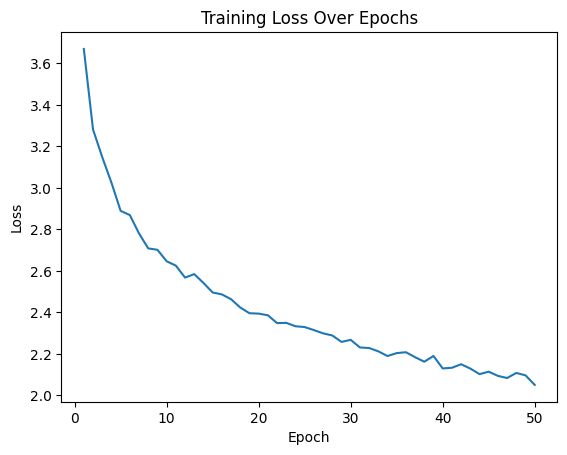

In [819]:
plt.plot(range(1, epoch + 1, print_every), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

### 存储模型

In [814]:
# torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load("./model.pth"))

<All keys matched successfully>

### 模型表现

In [815]:
model.eval()
with torch.no_grad():
    word_ids = tokenizer.encode("清明时节")
    src = torch.tensor([word_ids[:-2]]).to(DEVICE)
    tgt = torch.tensor([word_ids[-2:-1]]).to(DEVICE)
    # 一个一个词预测，直到预测为<eos>，或者达到句子最大长度
    for i in range(64):
        out = model(src, tgt)
        # 预测结果，只需最后一个词 
        # out: (1, tgt_s, h) ---> (1, 1, h) # ---> predict: (1, 1, v) 
        # ---argmax---> (1, 1) 找出最大值的index
        predict = model.predict(out[:,-1:,:])
        # predict = model.predict(out)
        # print(predict.size())
        # predict[0,0,[1,3,9,15,61,514,115,158,17,0]] = 0
        # predict[0,0,[1,15]] = 0
        # predict[0,0,9] = 0
        y = torch.argmax(predict, dim=-1)
        # 和之前的预测结果拼接到一起
        tgt = torch.cat([tgt, y], dim=1)
        # if y == tokenizer.eos_id or tgt.size()[1] == 64:
            # break
        # break

    src_decode = "".join([w for w in tokenizer.decode(src[0].tolist()) if w not in [Tokenizer.PAD, Tokenizer.UNKNOWN]])
    print(f"src = {src}, src_decode = {src_decode}")
    tgt_decode = "".join([w for w in tokenizer.decode(tgt[0].tolist()) if w not in [Tokenizer.PAD, Tokenizer.UNKNOWN]])
    print(f"tgt = {tgt}, tgt_decode = {tgt_decode}")
    print(f"完整诗句：{src_decode + tgt_decode}")

src = tensor([[  2, 403, 235, 293]]), src_decode = 清明时
tgt = tensor([[197,   9,  10,  55,  61, 216,  10,  15,  61, 934,  24, 116, 486,   9,
         148, 327, 234,  55, 350,  15,   3,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
           1,   1,   1,   1,   1,   1,   1,   1,   1]]), tgt_decode = 节，春色不如春。不见花枝上，犹疑月色中。
完整诗句：清明时节，春色不如春。不见花枝上，犹疑月色中。
